# Teeth Caries UNET


https://arxiv.org/pdf/1505.04597.pdf

In [ ]:
!pip install imantics --quiet


  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d thunderpede/panoramic-dental-dataset

 92% 224M/244M [00:00<00:00, 307MB/s]
100% 244M/244M [00:00<00:00, 284MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/panoramic-dental-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
images_dir ='/content/images_cut'
masks_dir = '/content/labels_cut'

In [ ]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [ ]:
print(len(images_listdir))
print(len(masks_listdir))

100
100


In [ ]:
image_size=512
input_image_size=(512,512)

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
number=200

# Input images

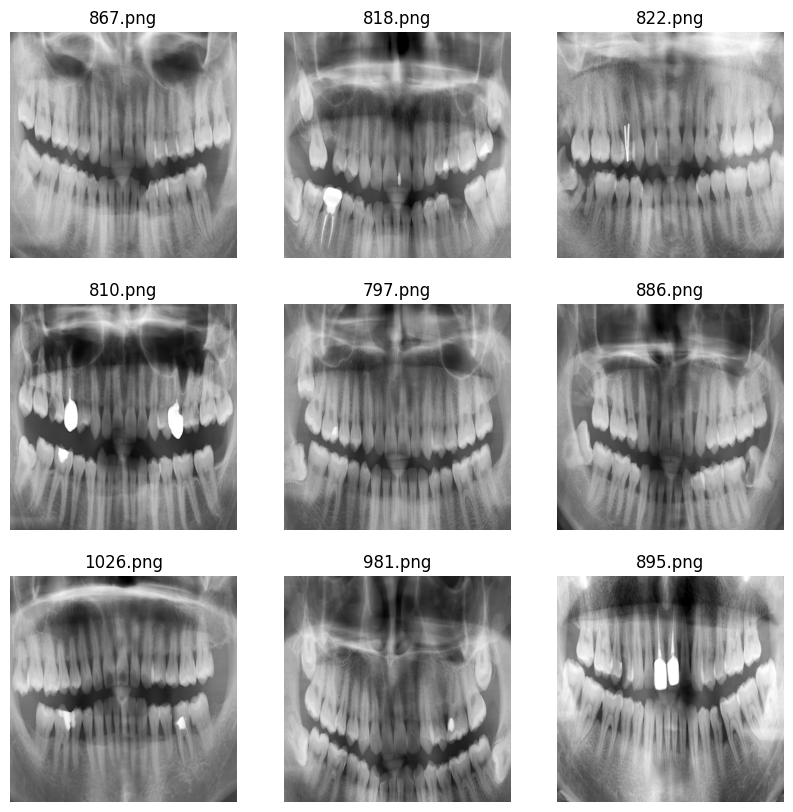

In [ ]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

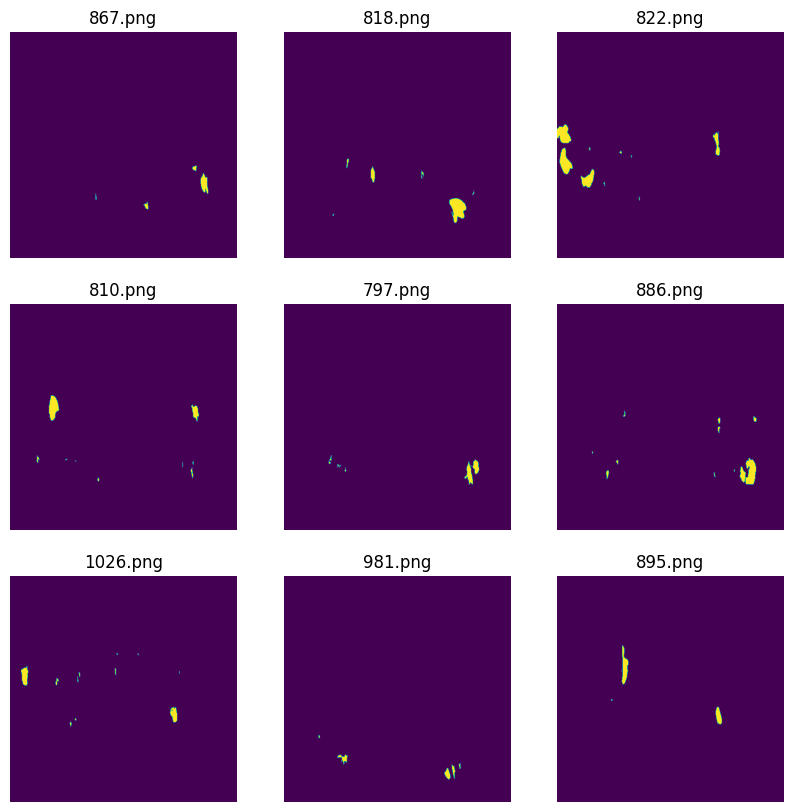

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [ ]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [ ]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [ ]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [ ]:
print(len(images_train), len(masks_train))

60 60


# U-Net

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train
Suitable number epoch range is narrow.

In [ ]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 120)

# Save the model
unet_model.save("/content/drive/MyDrive/model_cavity.h5")


Epoch 1/120
12/12 [==============================] - 70s 1s/step - loss: -3.6373 - accuracy: 0.5697 - val_loss: 93372.3516 - val_accuracy: 0.0000e+00
Epoch 2/120
12/12 [==============================] - 13s 1s/step - loss: -11.1446 - accuracy: 0.8011 - val_loss: 10191.7197 - val_accuracy: 0.0013
Epoch 3/120
12/12 [==============================] - 13s 1s/step - loss: -16.1194 - accuracy: 0.8183 - val_loss: -443545.3750 - val_accuracy: 0.0000e+00
Epoch 4/120
12/12 [==============================] - 13s 1s/step - loss: -20.1803 - accuracy: 0.6692 - val_loss: -8953.0225 - val_accuracy: 5.7220e-06
Epoch 5/120
12/12 [==============================] - 13s 1s/step - loss: -27.5660 - accuracy: 0.6634 - val_loss: -1766.6288 - val_accuracy: 1.4305e-04
Epoch 6/120
12/12 [==============================] - 13s 1s/step - loss: -29.5668 - accuracy: 0.5599 - val_loss: -1224.3506 - val_accuracy: 6.9936e-06
Epoch 7/120
12/12 [==============================] - 13s 1s/step - loss: -38.6542 - accuracy: 0.4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict valid images

In [ ]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
prediction = unet_model.predict(images_test, batch_size=1)

40/40 [==============================] - 9s 96ms/step


In [ ]:
len(images_test)

40

In [ ]:
r1,r2,r3,r4,r5=0.5,0.6,0.7,0.8,0.9

In [ ]:
unet_predict1 = (prediction > r1).astype(np.uint8)
unet_predict2 = (prediction > r2).astype(np.uint8)
unet_predict3 = (prediction > r3).astype(np.uint8)
unet_predict4 = (prediction > r4).astype(np.uint8)
unet_predict5 = (prediction > r5).astype(np.uint8)

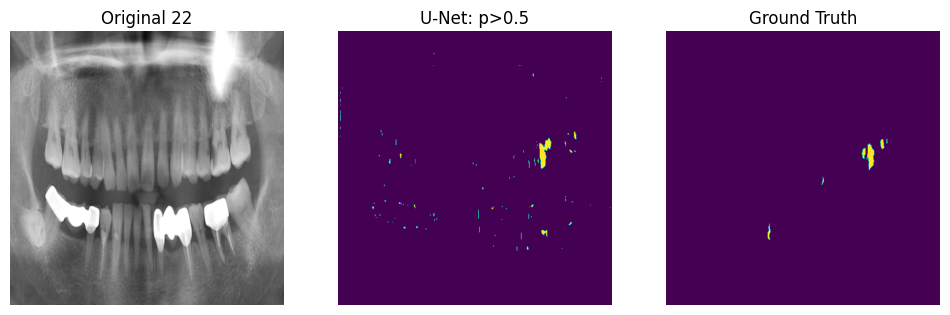

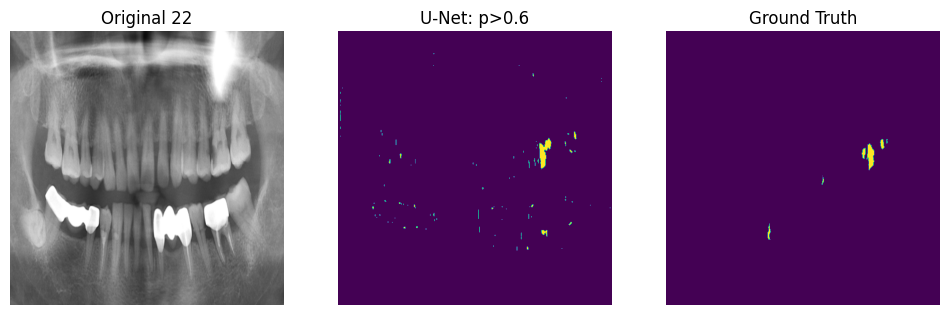

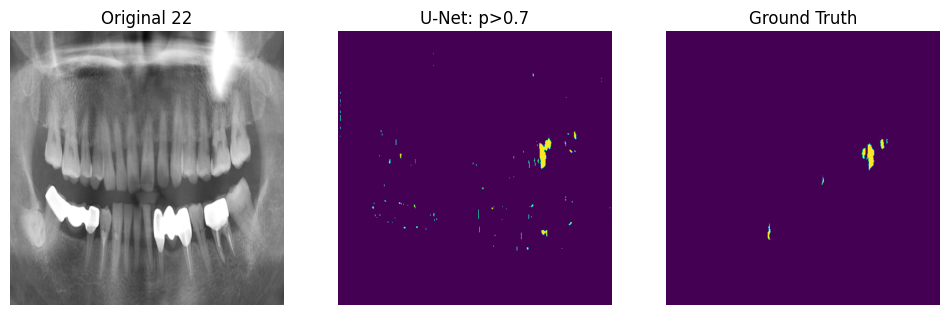

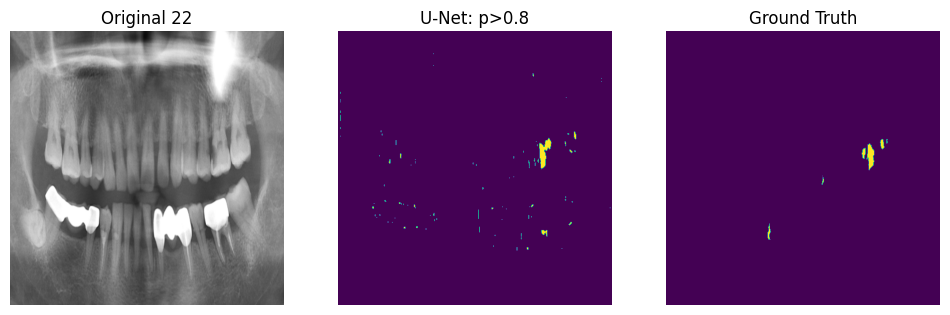

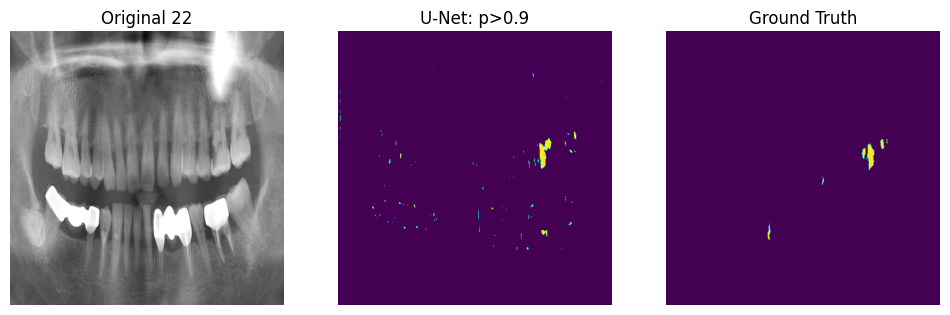

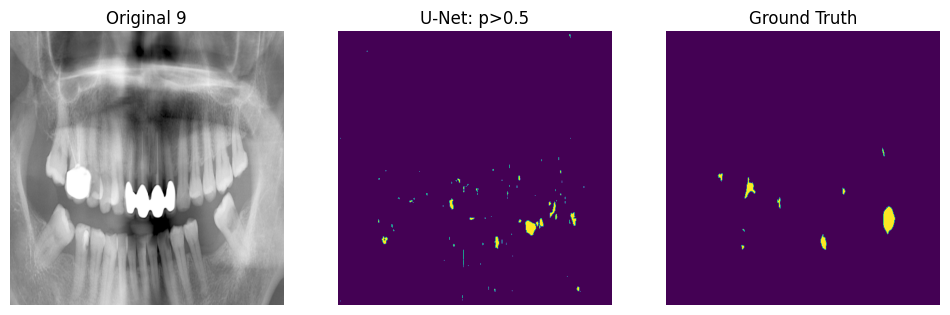

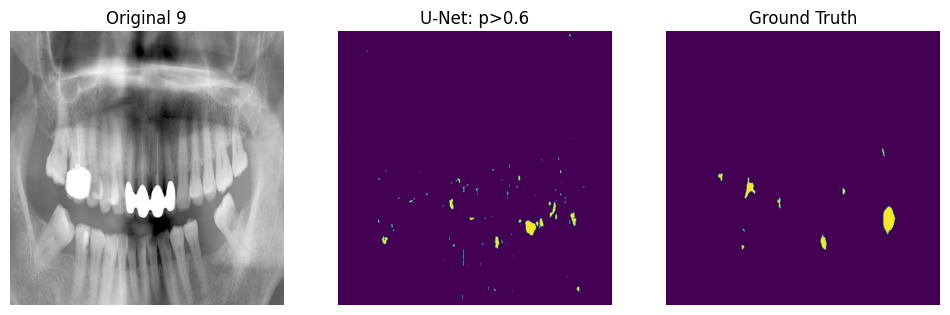

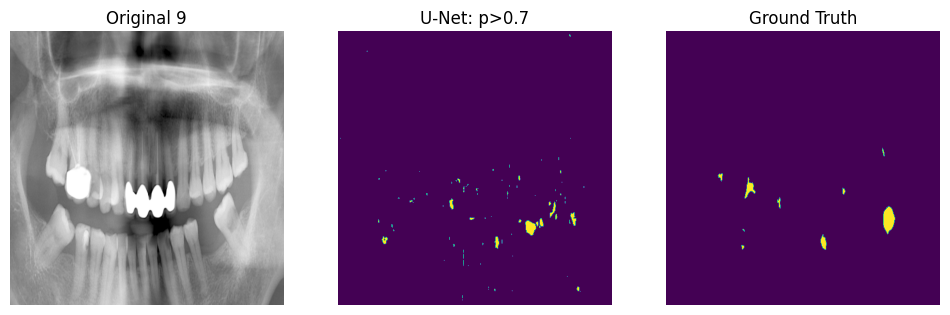

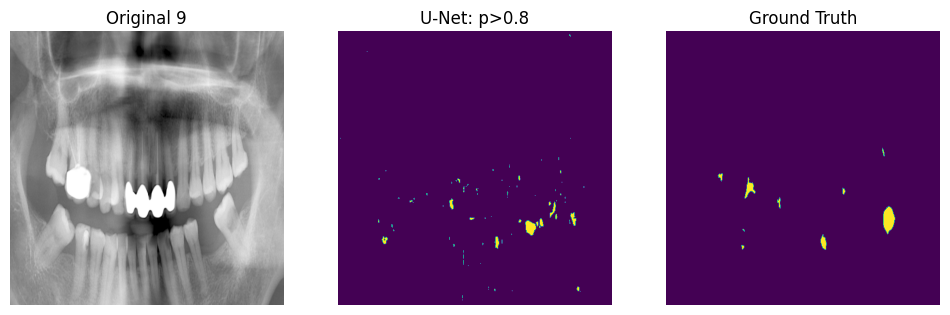

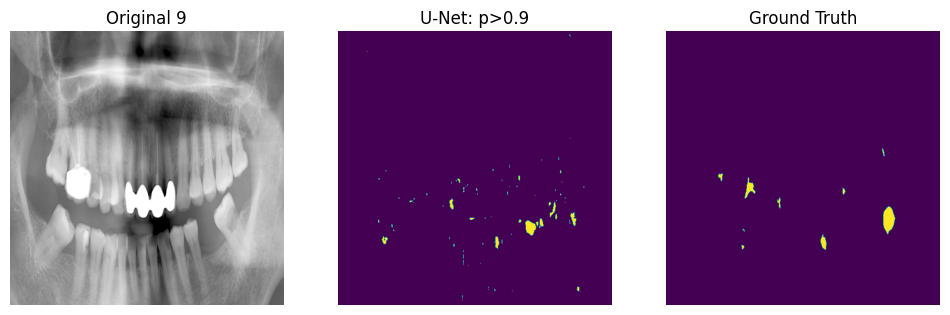

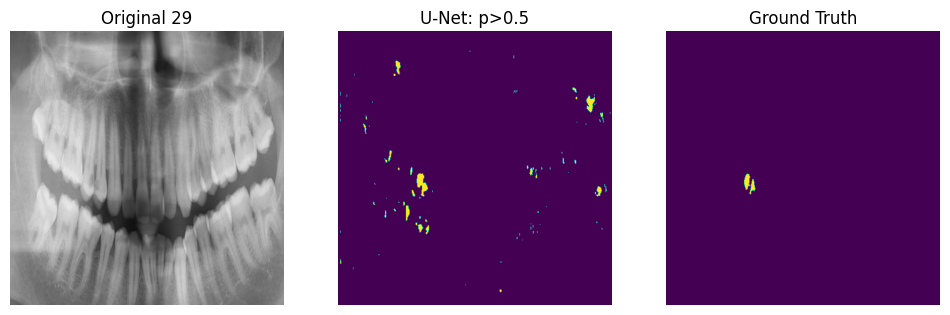

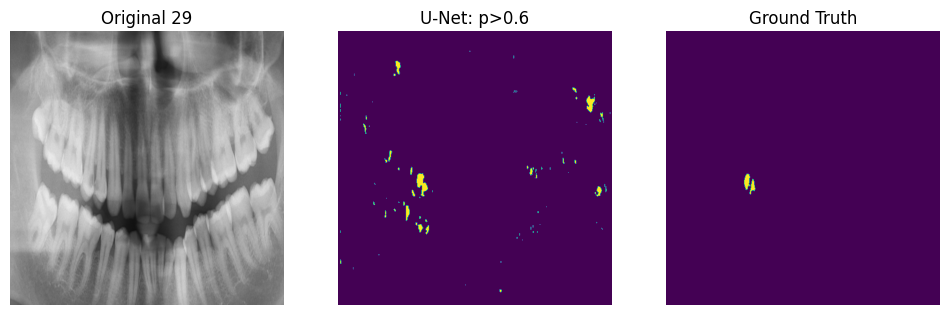

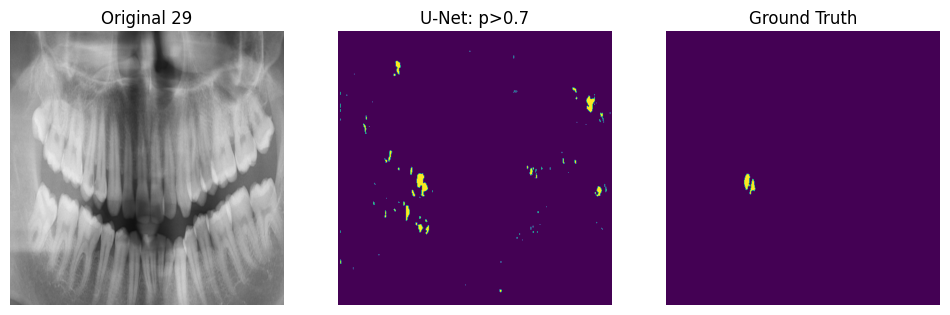

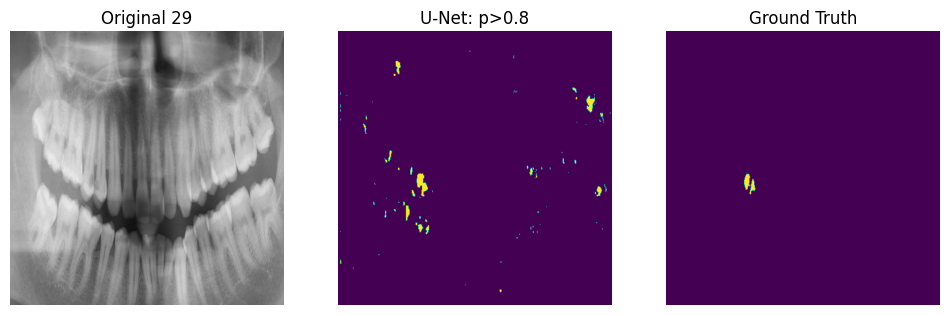

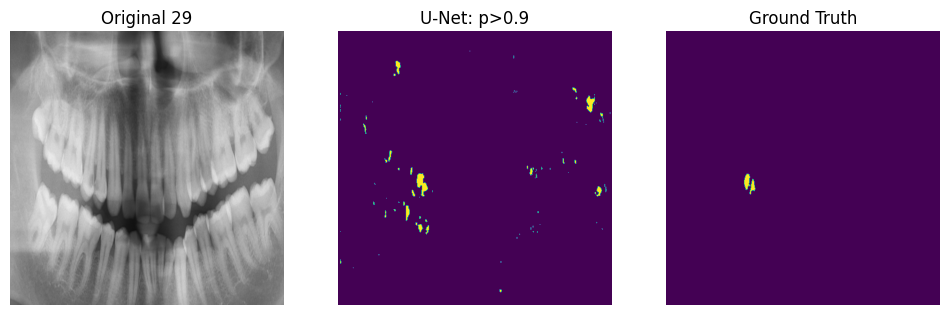

In [ ]:
show_test_idx = random.sample(range(len(prediction)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    show_result(idx, images_test[idx], unet_predict5[idx], masks_test[idx], r5)
    print()

In [ ]:
import tensorflow as tf

# Load the pre-trained model
pretrained_model_path = "/content/drive/MyDrive/model_cavity.h5"
unet_model = tf.keras.models.load_model(pretrained_model_path)

# Compile the model with desired optimizer, loss function, and metrics
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model for 100 epochs
fine_tune_result = unet_model.fit(
    images_train, masks_train,
    validation_split=0.2,
    batch_size=4,
    epochs=100
)

# Save the fine-tuned model
fine_tuned_model_path = "/content/drive/MyDrive/fine_tuned_model_cavity.h5"
unet_model.save(fine_tuned_model_path)


Epoch 1/100
12/12 [==============================] - 25s 1s/step - loss: -3718.2903 - accuracy: 0.7641 - val_loss: -189.0093 - val_accuracy: 0.9816
Epoch 2/100
12/12 [==============================] - 14s 1s/step - loss: -3754.4133 - accuracy: 0.7933 - val_loss: -297.2760 - val_accuracy: 0.9859
Epoch 3/100
12/12 [==============================] - 13s 1s/step - loss: -3818.6387 - accuracy: 0.8144 - val_loss: -75.4624 - val_accuracy: 0.9865
Epoch 4/100
12/12 [==============================] - 13s 1s/step - loss: -3849.4309 - accuracy: 0.8299 - val_loss: -309.8563 - val_accuracy: 0.9827
Epoch 5/100
12/12 [==============================] - 13s 1s/step - loss: -3898.5938 - accuracy: 0.8250 - val_loss: -346.0371 - val_accuracy: 0.9828
Epoch 6/100
12/12 [==============================] - 13s 1s/step - loss: -3948.8450 - accuracy: 0.8378 - val_loss: -256.4019 - val_accuracy: 0.9858
Epoch 7/100
12/12 [==============================] - 13s 1s/step - loss: -3991.1536 - accuracy: 0.7792 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict valid images

In [ ]:
pretrained_model_path = "/content/drive/MyDrive/fine_tuned_model_cavity.h5"
unet_model2 = tf.keras.models.load_model(pretrained_model_path)


In [ ]:
prediction2 = unet_model2.predict(images_test, batch_size=1)

40/40 [==============================] - 4s 95ms/step


In [ ]:
len(images_test)

40

In [ ]:
r1,r2,r3,r4,r5=0.5,0.6,0.7,0.8,0.9

In [ ]:
unet_predict21 = (prediction2 > r1).astype(np.uint8)
unet_predict22 = (prediction2 > r2).astype(np.uint8)
unet_predict23 = (prediction2 > r3).astype(np.uint8)
unet_predict24 = (prediction2 > r4).astype(np.uint8)
unet_predict25 = (prediction2 > r5).astype(np.uint8)

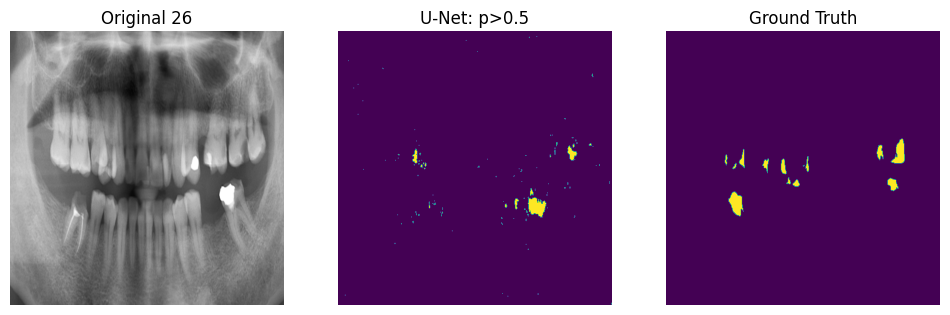

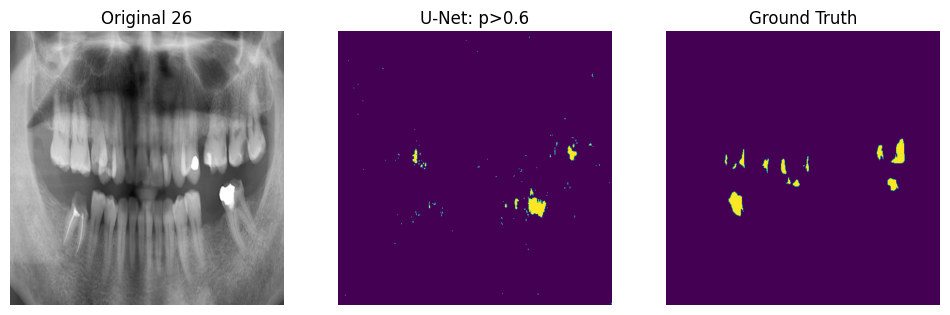

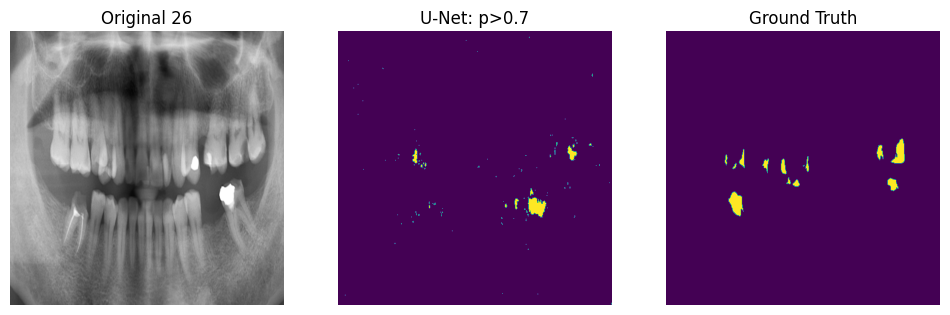

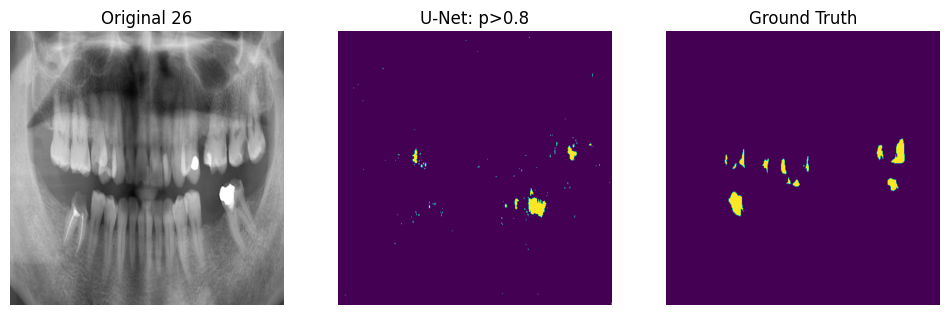

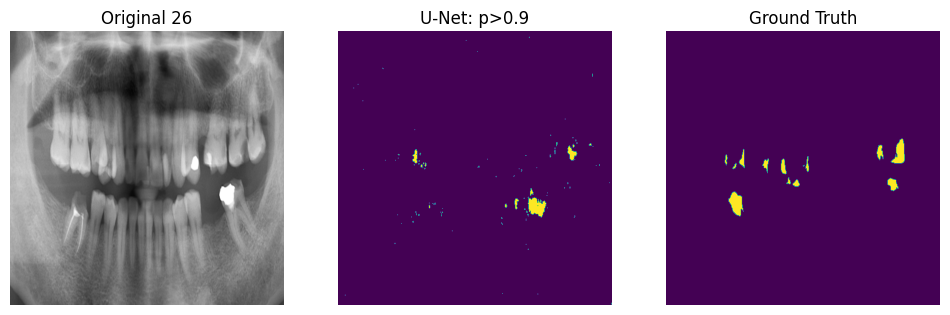

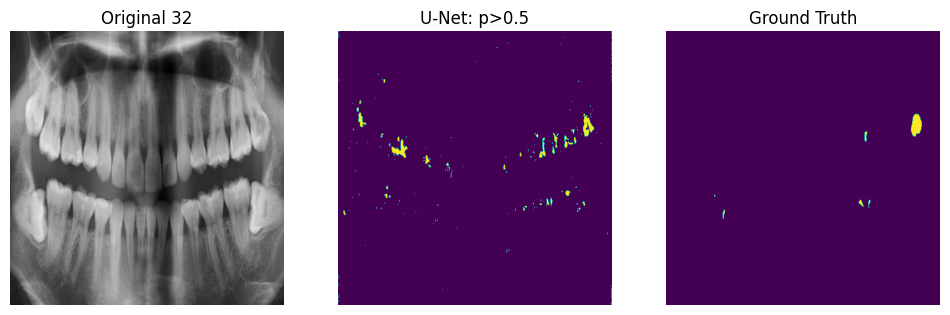

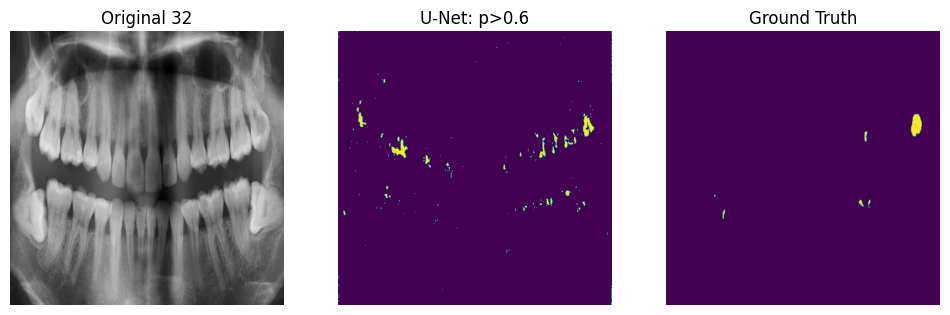

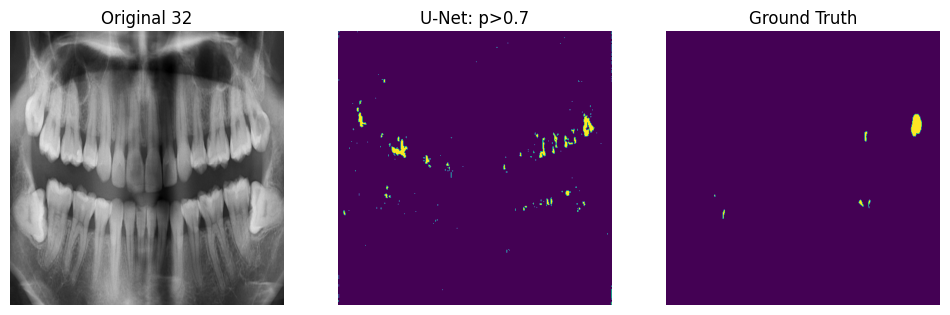

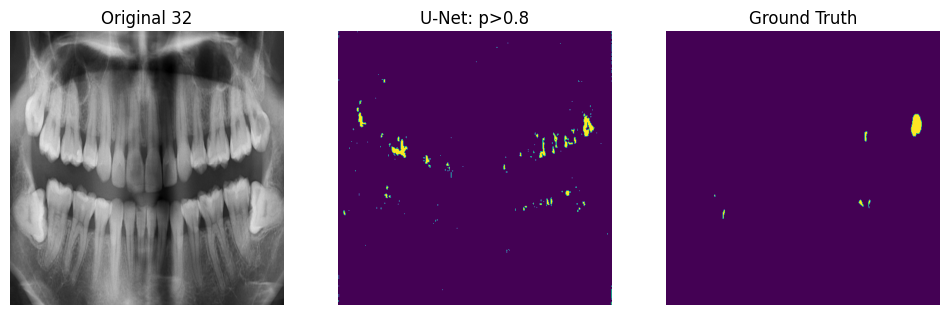

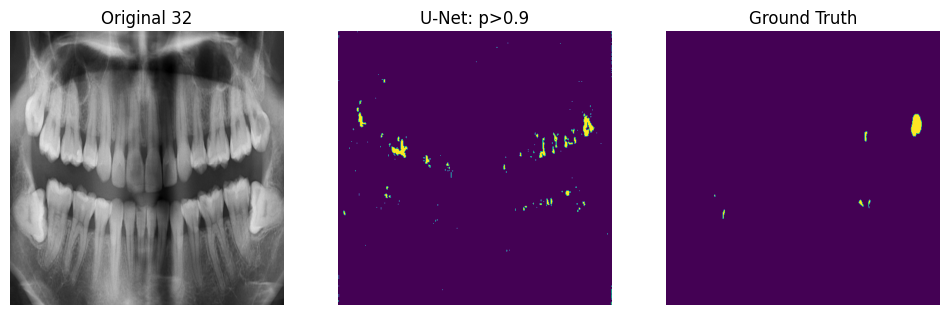

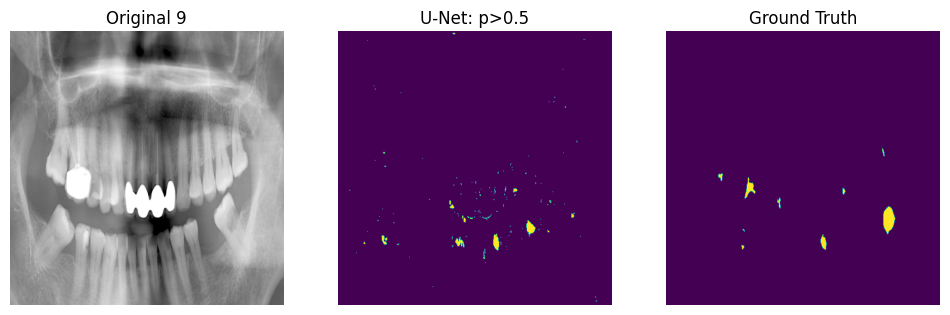

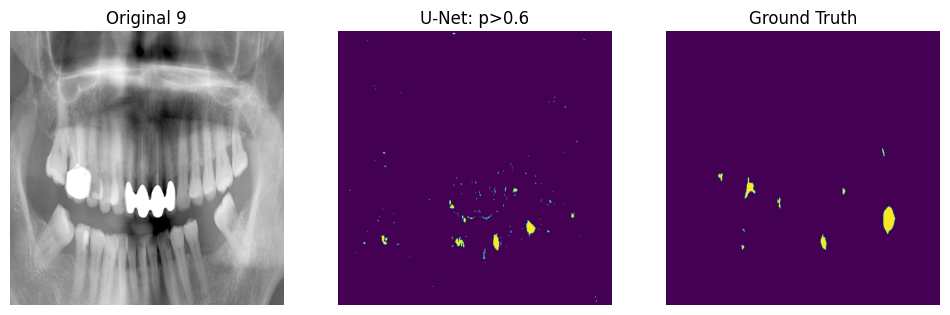

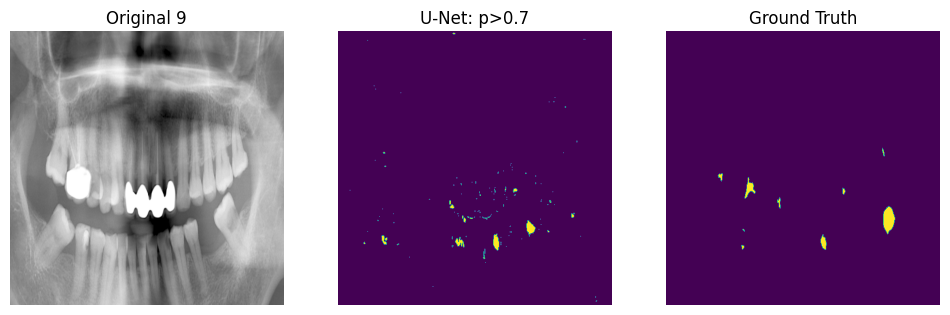

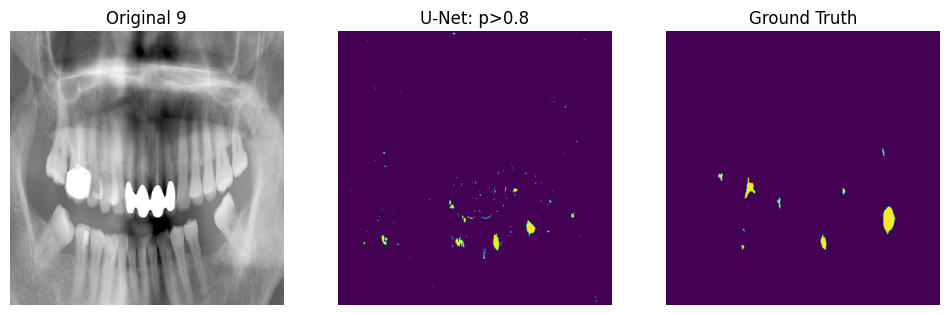

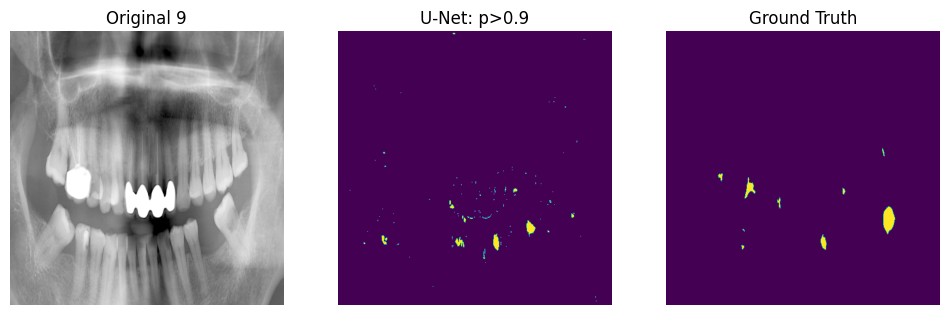

In [ ]:
show_test_idx = random.sample(range(len(prediction)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict21[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict22[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict23[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict24[idx], masks_test[idx], r4)
    show_result(idx, images_test[idx], unet_predict25[idx], masks_test[idx], r5)
    print()